# A Look at Customer Churn at Telco

<hr style="border-top: 50px groove brown; margin-top: 1px; margin-bottom: 1px"></hr>

## Project Goals: 

The goals of this project are to identify the drivers of customer churn at Telco, produce a prediction model to 
identify the customers who are at a greater risk of churn, and offer recommendations for reducing such churns.

## Project Description:

I will compare the customers that have churned with those who have not. I will analyze the attributes that are driving the churn and build a prediction model. This model will provide a list of customers who are more likely to churn in form of predictions.csv. Finally, I will recommend courses of action to help promote customer retention.

## Initial Questions:

1. What portion of customers are churning?

2. What is the timeline of the most churn?

3. Do the customers who churner pay higher monthly charges? 

4. Does contract type determine those customers who like churn?

5. Does how customer pay the bill matter?

## Imports

In [1]:
#get all the neccessary imports
import pandas as pd
import numpy as np

import acquire
import prepare

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import scipy.stats as stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Acquire Data

I acquired the Telco customer data from Telco_churn database from MySQL hosted at data.codeup.com. The code needed to acquire the data from the CodeUp database can be found in the acquire.py file. Access credentials are required to access the CodeUp database. The acquire file also creates a local copy of the dataframe as telco.csv.

In [2]:
#acquire telco data 
telco = acquire.get_telco_data()

## Prepare Data

The code for data step 1: clean up and and step 2: split can be found in the prepare file

In [3]:
#take a peek at the data
telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [4]:
# how big is the data?
telco.shape

(7043, 24)

In [5]:
# get more info of the columns
telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

    Columns with dataype object will need to be hot encoded

In [6]:
#total charges column has 11 empty space
telco.total_charges.value_counts()

           11
20.2       11
19.75       9
19.9        8
20.05       8
           ..
2387.75     1
6302.8      1
2058.5      1
829.55      1
3707.6      1
Name: total_charges, Length: 6531, dtype: int64

Clean Data

1. Replaced 11 blank values in column "total_charges" with 0. The tenure associated with those columns was 0. Thus I decided that the total charge has not piled up on them yet. Customer with tenure 1 month had same monthly and total charges
2. Converted column "total_charges" to float
3. Removed duplicate columns
4. Encoded dummies variables for all discrete variables used during modeling
5. Cleaned up column names

Split data

1. Data splited in to 3 samples of train (60%), validate(20%) and test(20%)
2. Our target is churn

In [4]:
# get the split data from import called prepare
train,validate,test = prepare.prep_telco_data(telco)

In [8]:
#take a peek at the split
[train.shape,validate.shape,test.shape]

[(4225, 48), (1409, 48), (1409, 48)]

I did not drop columns which I hot encoded for modeling.

## Explore Data

    Important note: I will do exploration analysis only in train data

Answers to my initial questions:

    1. What portion of customers are churning?

In [9]:
#calculate churn percent using mean
churn_mean = round((train.churn_encoded).mean() *100)
churn_mean

27

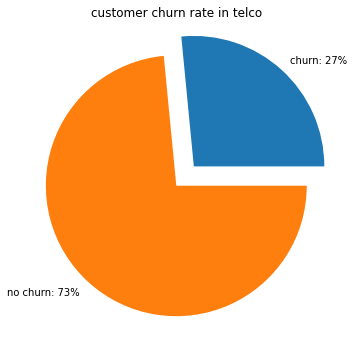

In [10]:
#visualise churn in a pie chart
plt.figure(figsize = (10,6))
plt.title("customer churn rate in telco")
labels = ["churn: 27%", "no churn: 73%"]
plt.pie([(train.churn == 'Yes').sum(), (train.churn == 'No').sum()], labels=labels, explode = [0.2,0])
plt.show()

    27% of customers are churning.

    2. What is the timeline of the most churn?

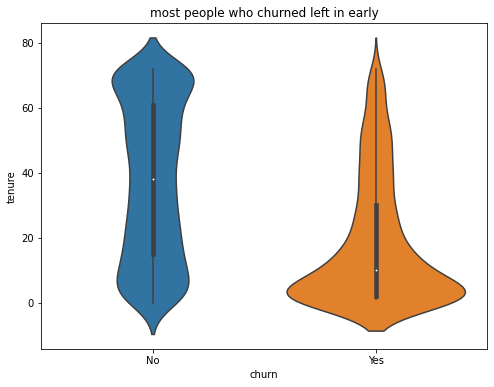

In [11]:
#create a violion plot to vizualize churn vs tenure
plt.figure(figsize = (8,6))
plt.title("most people who churned left in early")
sns.violinplot(x = "churn",y = "tenure", data = train)
plt.show()

    Most churn occurs in the early months, steep churn rate

    3. Do the customers who churner pay higher monthly charges? 

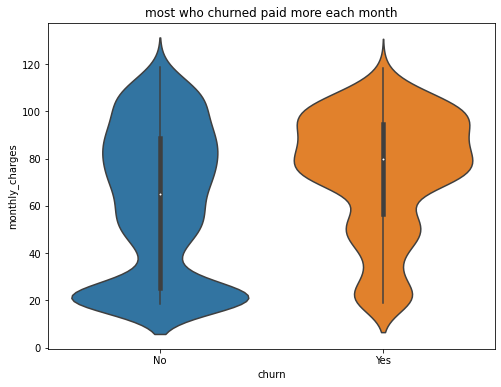

In [12]:
#create violin plot to visualise churn vs monthly charges
plt.figure(figsize = (8,6))
plt.title("most who churned paid more each month")
sns.violinplot(x = "churn",y = "monthly_charges", data = train)
plt.show()

We will do t-test here, compare the mean of monthly charges in churn vs not churn

In [13]:
#create subgroup of monthly charges
train_yes_churn= train[train.churn_encoded == 1].monthly_charges
train_no_churn= train[train.churn_encoded == 0].monthly_charges

# run levene test to compare variance
null_hyp = "variances  are equal"
alt_hyp = "variances are not equal"
alpha = 0.05
t,p_levene = stats.levene(train_yes_churn, train_no_churn)
if p_levene < alpha:
    print("reject null hypothesis and conclude", alt_hyp)
else:
    print("fail to reject null hypothesis and conclude" , null_hyp)

reject null hypothesis and conclude variances are not equal


In [14]:
#run t-test on the compare the tow sub means
null_hyp = "no difference in monthly charges of people who churned and who did not"
alt_hyp = "there is difference in monthly charge of people who churned and who did not"
t,p = stats.ttest_ind(train_yes_churn, train_no_churn, equal_var = False)
if p < alpha:
    print("reject null hypothesis and conclude", alt_hyp )
else:
    print("fail to reject null hypothesis and conclude", null_hyp)

reject null hypothesis and conclude there is difference in monthly charge of people who churned and who did not


    customers who churn usually pay higher in monthly charge on average

    4. Does contract type determine those customers who like churn?



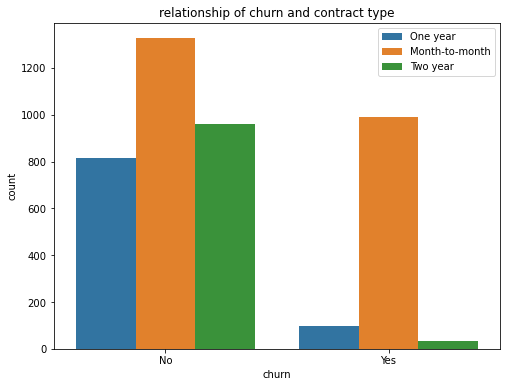

In [70]:
#create countplot to visualize churn vs contract type
plt.figure(figsize = (8,6))
plt.title("relationship of churn and contract type")
sns.countplot(hue = "contract_type", x = "churn", data = train)
plt.legend(loc="upper right")
plt.show()

In [19]:
null_hyp = 'contract type and churn rate are independent'
alt_hyp = 'contract type and churn rate are dependent'
observed = pd.crosstab(train.churn, train.contract_type)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print('reject the null hypothesis that and conclude', alt_hyp)
    
else:
    print('fail to reject the null hypothesis and conclude', null_hyp)

reject the null hypothesis that and conclude contract type and churn rate are dependent


    Month to month contract seem a very deal for telco

    5. Does how customers pay the bill matter?

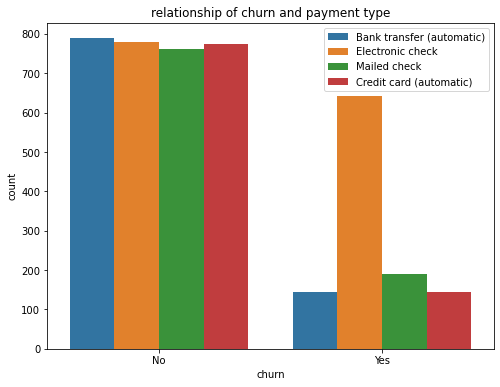

In [36]:
#create countplot to visualize churn vs contract type
plt.figure(figsize = (8,6))
plt.title("relationship of churn and payment type")
sns.countplot(hue = "payment_type", x = "churn", data = train)
plt.legend(loc="upper right")
plt.show()

In [39]:
#set up chi2 test on churn vs payment type
null_hyp = 'payment type and churn rate are independent'
alt_hyp = 'payment type and churn rate are dependent'
observed = pd.crosstab(train.churn, train.payment_type)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print('reject the null hypothesis that and conclude', alt_hyp)
    
else:
    print('fail to reject the null hypothesis and conclude', null_hyp)

reject the null hypothesis that and conclude payment type and churn rate are dependent


     need to transition customers to other form of payment

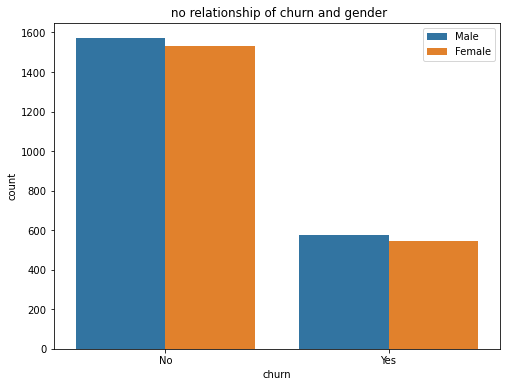

In [38]:
#create countplot to visualize churn vs gender type
plt.figure(figsize = (8,6))
plt.title(" no relationship of churn and gender")
sns.countplot(hue = "gender", x = "churn", data = train)
plt.legend(loc="upper right")
plt.show()

In [35]:
null_hyp = 'gender and churn rate are independent'
alt_hyp = 'gender and churn rate are dependent'
observed = pd.crosstab(train.churn, train.gender)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print('reject the null hypothesis that and conclude', alt_hyp)
    
else:
    print('fail to reject the null hypothesis and conclude', null_hyp)

fail to reject the null hypothesis and conclude gender and churn rate are independent


feature engineering: we will add all the services subscribed by the customers and take a look at the churn

In [15]:
# make a new column, add all the services used to each customers
train["added_services"] = (train[['phone_service','multiple_lines','online_security','online_backup',
                'device_protection','tech_support','streaming_tv','streaming_movies']] == "Yes").sum(axis =1 )

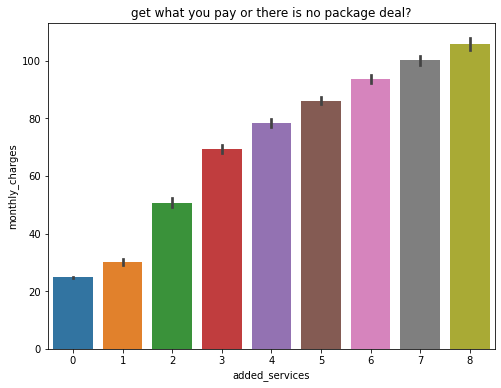

In [16]:
plt.figure(figsize = (8,6))
sns.barplot(x = "added_services", y = "monthly_charges", data = train)
plt.title("get what you pay or there is no package deal?")
plt.show()

    more the added services, higher is the monthly charge. 
    may need to give out package deals at lower costs, needs more investigation

how about lonely people?

In [17]:
#make new column with sum of customers with dependent or partner
train["dependent_and_partner"] = (train[["dependents", "partner"]] == "Yes").sum(axis =1)

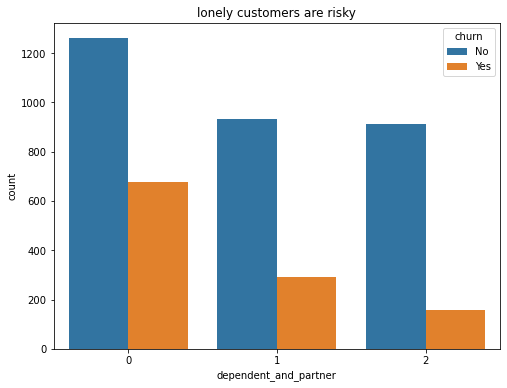

In [18]:
#create countplot to visualize churn vs customers with dependent or partner
plt.figure(figsize = (8,6))
plt.title("lonely customers are risky")
sns.countplot(x= train.dependent_and_partner, hue = train.churn)
plt.show()

In [19]:
#run group by at this column to get churn rate
train.groupby([ "dependent_and_partner"])["churn"].value_counts(normalize = True).mul(100)

dependent_and_partner  churn
0                      No       65.116279
                       Yes      34.883721
1                      No       76.268412
                       Yes      23.731588
2                      No       85.393258
                       Yes      14.606742
Name: churn, dtype: float64

    largest customers are share all burden of monthly charge, have high churn rate, 35%
    push for refferral discounts aggressively
    

From exploration, we choose our contract type, payment type, internet service type, online security, tech support, tenure, senior citizen and monthly charge for modeling

## Modeling

After we have identified our most drivers for churn, we used those features to create a supervised machine learning models that helped us identify the possible churn of any given customer. 

Churn is our target variable

We will use our training data to train/fit to our model and then tune the model on our validate data.

We will pick our best model on accuracy and recall. Since predicting churn is a positive case, we need to predict the customer who we falsely assume are not going to churn but actually do churn.

The three models used were

1. Decision tree
2. Randon forest
3. K-Nearest Neighbor

In [5]:
encoded_features =['contract_type_one_year', 'contract_type_two_year','payment_type_mailed_check','payment_type_credit_card_automatic', 'payment_type_electronic_check', 'internet_service_type_none', 'online_security_no_internet_service', 'online_security_yes',
                  'tech_support_no_internet_service','tech_support_yes', 'tech_support_yes','tenure','monthly_charges', 'senior_citizen','internet_service_type_fiber_optic']  

In [6]:
# X is going to be our entire domain, indepedent variables, minus the target variable
# y is going to be our target variable, the dependent thing that we are using X to predict
X_train = train[encoded_features]
y_train = train.churn_encoded
X_validate = validate[encoded_features]
y_validate = validate.churn_encoded
X_test = test[encoded_features]
y_test = test.churn_encoded

### Baseline Prediction:

A baseline prediction is a benchmark. It predicts the most prevelant class in the train data. We compare our model and want to it better than this baseline prediction.

In [24]:
# baseline prediction: baseline is the mode value
y_train.value_counts()

0    3104
1    1121
Name: churn_encoded, dtype: int64

In [25]:
# baseline prediction
(y_train == 0).mean()
print(f'Our baseline accuracy for churn in all cases is {(y_train == 0).mean():.3}')

Our baseline accuracy for churn in all cases is 0.735


### Model 1: Decision Tree (max_depth = 5)

In [26]:
#create decision tree classifier 
clf = DecisionTreeClassifier(max_depth=5, random_state=123)

#fit the random forest algorithm to the training data.
clf = clf.fit(X_train, y_train)

## make prediction on train obeservations
y_pred = clf.predict(X_train)

In [27]:
# make prediction on validate obeservations
y_pred_val = clf.predict(X_validate)

In [28]:
#create classification report for Model 1
print("train score")
print(classification_report(y_train, y_pred))
print()
print("validate score")
print(classification_report(y_validate, y_pred_val))

train score
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3104
           1       0.65      0.56      0.60      1121

    accuracy                           0.80      4225
   macro avg       0.75      0.72      0.73      4225
weighted avg       0.79      0.80      0.80      4225


validate score
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1035
           1       0.62      0.56      0.59       374

    accuracy                           0.79      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.79      0.79      1409



Model 2: Random Forest( min_samples_leaf= 14)

In [8]:
#create random forest classifier 
rf = RandomForestClassifier(min_samples_leaf= 14,random_state=123)

#fit the random forest algorithm to the training data.
rf = rf.fit(X_train, y_train)

## make prediction on train obeservations
y_pred = rf.predict(X_train)


In [30]:
# make prediction on validate obeservations
y_pred_val = rf.predict(X_validate)

In [31]:
#create classification report for Model 2
print("train score")
print(classification_report(y_train, y_pred))
print()
print("validate score")
print(classification_report(y_validate, y_pred_val))

train score
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3104
           1       0.70      0.52      0.60      1121

    accuracy                           0.81      4225
   macro avg       0.77      0.72      0.74      4225
weighted avg       0.80      0.81      0.80      4225


validate score
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



### model3: KNN

In [32]:
#create k-neightbor classifier 
knn = KNeighborsClassifier(n_neighbors = 24, weights = "uniform")
#fit the model
knn= knn.fit(X_train,y_train)
#make predictions of training data
y_pred = knn.predict(X_train)


In [34]:
#create classification report for Model 3
print("train score")
print(classification_report(y_train, y_pred))
print()
print("validate score")
print(classification_report(y_validate, y_pred_val))

train score
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      3104
           1       0.68      0.47      0.56      1121

    accuracy                           0.80      4225
   macro avg       0.75      0.70      0.71      4225
weighted avg       0.79      0.80      0.79      4225


validate score
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



Random forest model here has train accuracy of 81%, validate accuracy of 81% and recall 92% 
We are goint to use this model in test data

## Model Evaluation

We will use decision tree model on test data 

In [9]:
y_pred_test= rf.predict(X_test)
y_proba = rf.predict_proba(X_test)

In [10]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



In [11]:
print('Accuracy of Random Forest on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of Random Forest on test set: 0.80


In [12]:
print('Accuracy of Random Forest on validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of Random Forest on validate set: 0.81


In [45]:
print('Accuracy of Random Forest on train set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of Random Forest on train set: 0.81


## Predictions

In [ ]:
Create a csv file of the churn probabilty and prediction using the best model

In [13]:
#Creating empty DataFrame:
predictions = pd.DataFrame()
#Creating customer_id column:
predictions['customer_id'] = test.customer_id
#Creating prediction column:
predictions['prediction'] = y_pred_test
#Creating probability column:
predictions['probability'] = y_proba[:,1]
#convert to csv and export it to repo as csv
predictions.to_csv("predictions.csv")

In [14]:
predictions.head()

,customer_id,prediction,probability
3160,4531-AUZNK,0,0.164563
1577,2296-DKZFP,0,0.036528
6823,9692-TUSXH,1,0.556457
3615,5129-JLPIS,0,0.383372
882,1273-MTETI,1,0.706835


In [15]:
#export it to repo as csv
predictions.to_csv("predictions.csv",index = "False")

## Conclusion

## Recommendations

In [ ]:
1. Sign up deals that during early tenures that binds them in long term contract
2. Get in to 